# 信用情報の学習
# 【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。


- 何を学習し、何を予測するのか
- どのようなファイルを作りKaggleに提出するか
- 提出されたものはどういった指標値で評価されるのか

### 何を学習し、何を予測するのか
trainデータを使いmodel作成を行う  
testデータからTAAGET変数を予測する  

### どのようなファイルを作りKaggleに提出するか

IDとTARGETの2列からなるファイルを作成し、提出する

### 提出されたものはどういった指標値で評価されるのか

ROC曲線の下側(AUC)での評価となる

# 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。


検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。


分析の時にいい特徴量になりそうな４つを使用してモデル作成を行う

- CODE_GENDER
- NAME_FAMILY_STATUS
- AMT_CREDIT
- DAYS_BIRTH

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dataset = pd.read_csv('application_train.csv')
df = dataset[0:10000]

In [2]:
y = df['TARGET'].copy()
x = df[['CODE_GENDER', 'NAME_FAMILY_STATUS', 'AMT_CREDIT', 'DAYS_BIRTH']].copy()
df_test = df[['TARGET', 'CODE_GENDER', 'NAME_FAMILY_STATUS', 'AMT_CREDIT', 'DAYS_BIRTH']].copy()

In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TARGET              10000 non-null  int64  
 1   CODE_GENDER         10000 non-null  object 
 2   NAME_FAMILY_STATUS  10000 non-null  object 
 3   AMT_CREDIT          10000 non-null  float64
 4   DAYS_BIRTH          10000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 390.8+ KB


##  ダミー変数作成

In [4]:
x['CODE_GENDER'] 

0       M
1       F
2       M
3       F
4       M
       ..
9995    F
9996    F
9997    M
9998    F
9999    M
Name: CODE_GENDER, Length: 10000, dtype: object

In [5]:
x['CODE_GENDER'] = x['CODE_GENDER'].map({'M' : 0, 'F' : 1}).astype(int) # 性別のダミー変数
x['NAME_FAMILY_STATUS'] = x['NAME_FAMILY_STATUS'].map({'Civil marriage' : 0, 'Married' : 1, 'Separated' : 2, 'Single / not married' : 3, 'Widow' : 4}).astype(int) # 性別のダミー変数

In [6]:
x.head()

,CODE_GENDER,NAME_FAMILY_STATUS,AMT_CREDIT,DAYS_BIRTH
0,0,3,406597.5,-9461
1,1,1,1293502.5,-16765
2,0,3,135000.0,-19046
3,1,0,312682.5,-19005
4,0,3,513000.0,-19932


## 相関図

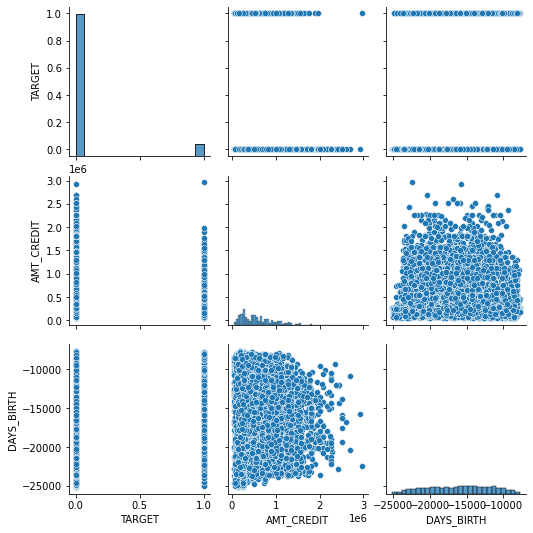

In [7]:
import seaborn as sns
sns.pairplot(df_test);

##  データの切り分け

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(x.values, random_state=0).copy()
y_train, y_true = train_test_split(y.values, random_state=0).copy()

## ベースラインモデル作成

In [9]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as me
from sklearn.metrics import classification_report

logi = LogisticRegression()
logi.fit(x_train, y_train)
logi_pred = logi.predict(x_test)
logi_confusion = me.confusion_matrix(y_true, logi_pred) 
print(logi_confusion) # 混同行列
print(classification_report(y_true, logi_pred))

[[2306    0]
 [ 194    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2306
           1       0.00      0.00      0.00       194

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,th_all,tpr_all,fpr_all
0,1.232335,0.000000,0.000000
1,0.232335,0.000000,0.000434
2,0.230754,0.000000,0.001301
3,0.229561,0.005155,0.001301
4,0.210383,0.005155,0.012142
...,...,...,...
353,0.023893,0.989691,0.969644
354,0.017928,0.989691,0.996964
355,0.017884,0.994845,0.996964
356,0.014933,0.994845,1.000000


AUC : 0.6148863118176697


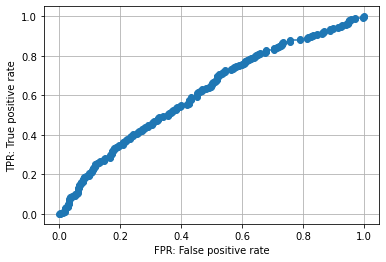

In [10]:
from sklearn.metrics import roc_auc_score
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, logi.predict_proba(x_test)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, logi.predict_proba(x_test)[:, 1])))

# 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。


どの特徴量を使うか
どう前処理をするか

何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。

## 学習方法の判断
### 近傍法

In [11]:
from sklearn.neighbors import KNeighborsClassifier
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(x_train, y_train) # 機械に学ばせている
KNN5_pred = neigh5.predict(x_test) # 検証データを渡して、結果を得る
print(np.sum(KNN5_pred==0)) # pythonではTrueを1としてあつかうため合計値でいける
print(np.sum(KNN5_pred==1))

2480
20


結果をみると0の割合が高すぎるのか1を表示できなかった。  
k近傍法は目的変数の数が同じじゃないと使いづらい？？？  
少しチューニング

In [12]:
neigh3 = KNeighborsClassifier(n_neighbors=3)
neigh3.fit(x_train, y_train) # 機械に学ばせている
KNN3_pred = neigh3.predict(x_test) # 検証データを渡して、結果を得る
print(np.sum(KNN3_pred==0))
print(np.sum(KNN3_pred==1))

2448
52


In [13]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(x_train, y_train) # 機械に学ばせている
KNN1_pred = neigh1.predict(x_test) # 検証データを渡して、結果を得る
print(np.sum(KNN1_pred==0))
print(np.sum(KNN1_pred==1))

2324
176


In [14]:
import sklearn.metrics as me
from sklearn.metrics import classification_report
knn5_confusion = me.confusion_matrix(y_true, KNN5_pred) 
print(knn5_confusion) # 混同行列
print(classification_report(y_true, KNN5_pred))

[[2287   19]
 [ 193    1]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      2306
           1       0.05      0.01      0.01       194

    accuracy                           0.92      2500
   macro avg       0.49      0.50      0.48      2500
weighted avg       0.85      0.92      0.88      2500



In [15]:
knn3_confusion = me.confusion_matrix(y_true, KNN3_pred) 
print(knn3_confusion) # 混同行列
print(classification_report(y_true, KNN3_pred))

[[2262   44]
 [ 186    8]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2306
           1       0.15      0.04      0.07       194

    accuracy                           0.91      2500
   macro avg       0.54      0.51      0.51      2500
weighted avg       0.86      0.91      0.88      2500



In [16]:
knn1_confusion = me.confusion_matrix(y_true, KNN1_pred) 
print(knn1_confusion) # 混同行列
print(classification_report(y_true, KNN1_pred))

[[2148  158]
 [ 176   18]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2306
           1       0.10      0.09      0.10       194

    accuracy                           0.87      2500
   macro avg       0.51      0.51      0.51      2500
weighted avg       0.86      0.87      0.86      2500



正解率は高いが、正解ラベル判断精度はかなり低い  
正解ラベルの特徴をうまく抜き出せていない証拠

In [17]:
unique_name, count = np.unique(neigh3.predict_proba(x_test)[:, 1], return_counts=True) # 閾値とそれを超える値を格納
pd.DataFrame(list(zip(unique_name, count)), columns = ['unique_name','count'])

,unique_name,count
0,0.000000,1986
1,0.333333,462
2,0.666667,52


0.6時点ではかなり生き残ってる

,th_all,tpr_all,fpr_all
0,1.666667,0.000000,0.000000
1,0.666667,0.041237,0.019081
2,0.333333,0.247423,0.202082
3,0.000000,1.000000,1.000000


AUC : 0.5244767124757468


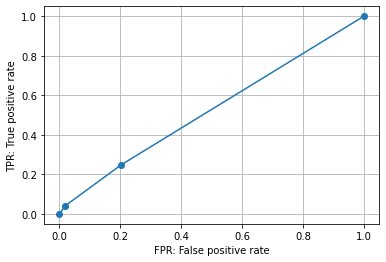

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, neigh3.predict_proba(x_test)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, neigh3.predict_proba(x_test)[:, 1])))

### ランダムフォレスト

In [19]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
clf_pred = clf.predict(x_test)
clf_confusion = me.confusion_matrix(y_true, clf_pred) 
print(clf_confusion) # 混同行列
print(classification_report(y_true, clf_pred))

[[2283   23]
 [ 191    3]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      2306
           1       0.12      0.02      0.03       194

    accuracy                           0.91      2500
   macro avg       0.52      0.50      0.49      2500
weighted avg       0.86      0.91      0.88      2500



In [20]:
unique_name, count = np.unique(clf.predict_proba(x_test)[:, 1], return_counts=True) # 正解ラベル１を取る確率関数
pd.DataFrame(list(zip(unique_name, count)), columns = ['unique_name','count'])

,unique_name,count
0,0.0000,544
1,0.0025,1
2,0.0100,308
3,0.0150,1
4,0.0200,228
...,...,...
75,0.6500,1
76,0.6800,1
77,0.6900,2
78,0.7500,1


,th_all,tpr_all,fpr_all
0,1.7600,0.000000,0.000000
1,0.7600,0.000000,0.000434
2,0.7500,0.000000,0.000867
3,0.6900,0.005155,0.001301
4,0.6300,0.005155,0.003036
...,...,...,...
67,0.0200,0.711340,0.653946
68,0.0150,0.711340,0.654380
69,0.0100,0.793814,0.781006
70,0.0025,0.793814,0.781440


AUC : 0.5419322967426972


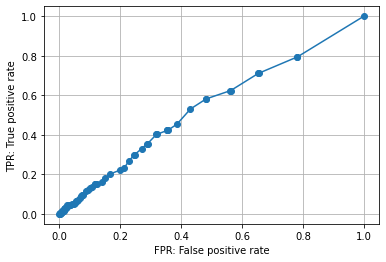

In [21]:
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, clf.predict_proba(x_test)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, clf.predict_proba(x_test)[:, 1])))

ランダムフォレストの場合デフォルトでサンプリングを100回行うので確率分布はかなり細かくなる。  
そのパラメータを変更すると...

In [22]:
clf_1000 = RandomForestClassifier(n_estimators=1000)
clf_1000.fit(x_train, y_train)
clf_1000_pred = clf_1000.predict(x_test)
clf_1000_confusion = me.confusion_matrix(y_true, clf_1000_pred) 
print(clf_1000_confusion) # 混同行列
print(classification_report(y_true, clf_1000_pred))

[[2278   28]
 [ 192    2]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2306
           1       0.07      0.01      0.02       194

    accuracy                           0.91      2500
   macro avg       0.49      0.50      0.49      2500
weighted avg       0.86      0.91      0.88      2500



,th_all,tpr_all,fpr_all
0,1.70500,0.000000,0.000000
1,0.70500,0.000000,0.000434
2,0.64400,0.000000,0.003036
3,0.64100,0.005155,0.003036
4,0.54500,0.005155,0.009974
...,...,...,...
318,0.00300,0.891753,0.874241
319,0.00275,0.891753,0.874675
320,0.00200,0.927835,0.903729
321,0.00100,0.963918,0.943625


AUC : 0.5525388721488542


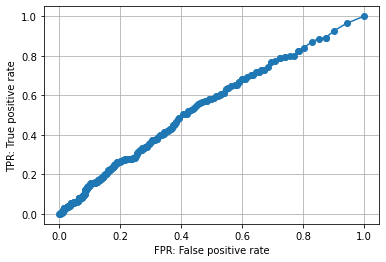

In [23]:
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, clf_1000.predict_proba(x_test)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, clf_1000.predict_proba(x_test)[:, 1])))

おおむね予想通りの結果出力となった。

### 決定木

In [24]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
dtc_pred = dtc.predict(x_test)
dtc_confusion = me.confusion_matrix(y_true, dtc_pred) 
print(dtc_confusion) # 混同行列
print(classification_report(y_true, dtc_pred))

[[2121  185]
 [ 175   19]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2306
           1       0.09      0.10      0.10       194

    accuracy                           0.86      2500
   macro avg       0.51      0.51      0.51      2500
weighted avg       0.86      0.86      0.86      2500



In [25]:
unique_name, count = np.unique(dtc.predict_proba(x_test)[:, 1], return_counts=True) # 閾値とそれを超える値を格納
pd.DataFrame(list(zip(unique_name, count)), columns = ['unique_name','count'])

,unique_name,count
0,0.0,2294
1,0.5,2
2,1.0,204


おもってた結果には全くならなかった  
0.5で2個1で190個ってどういう意味なんだろうか  
そしたら190がTPで出力されそうなものだが  
決定木の場合閾値で判断してない説

,th_all,tpr_all,fpr_all
0,2.0,0.000000,0.000000
1,1.0,0.097938,0.080225
2,0.5,0.097938,0.081093
3,0.0,1.000000,1.000000


AUC : 0.5084651424790552


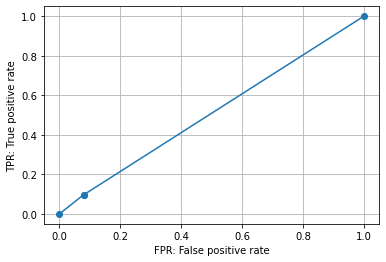

In [26]:
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, dtc.predict_proba(x_test)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, dtc.predict_proba(x_test)[:, 1])))

### SVC

In [27]:
from sklearn.svm import SVC
svc = SVC(probability=True) # probabilityで確率出力
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
svc_confusion = me.confusion_matrix(y_true, svc_pred) 
print(svc_confusion) # 混同行列
print(classification_report(y_true, svc_pred))

[[2306    0]
 [ 194    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2306
           1       0.00      0.00      0.00       194

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
unique_name, count = np.unique(svc.predict_proba(x_test)[:, 1], return_counts=True) # 閾値とそれを超える値を格納
pd.DataFrame(list(zip(unique_name, count)), columns = ['unique_name','count'])

,unique_name,count
0,0.071552,1
1,0.071552,1
2,0.071552,1
3,0.071552,1
4,0.071553,1
...,...,...
2495,0.231705,1
2496,0.277758,1
2497,0.277998,1
2498,0.400279,1


各データに対して　1を取る確率

,th_all,tpr_all,fpr_all
0,1.509128,0.000000,0.000000
1,0.509128,0.005155,0.000000
2,0.085847,0.005155,0.006071
3,0.085838,0.010309,0.006071
4,0.085174,0.010309,0.012142
...,...,...,...
348,0.071617,0.989691,0.981787
349,0.071612,0.994845,0.981787
350,0.071553,0.994845,0.997398
351,0.071553,1.000000,0.997398


AUC : 0.5032836795093034


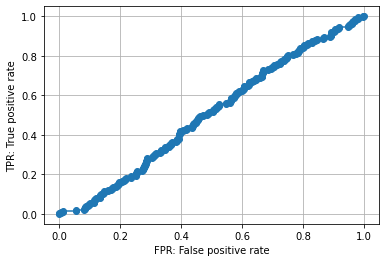

In [29]:
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, svc.predict_proba(x_test)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, svc.predict_proba(x_test)[:, 1])))

ひとつも正解ラベル見つけられてないという悲しき結果に  
閾値に関してはユニークが2500個(データの数ごとに確率だしてくれてる)のに362しか出力されていないし  
AUCに関してはおそらくだけど各データに対して0を推奨しているため、0.5より下に行ったんじゃないかなぁ

### ロジスティック回帰　

In [30]:
from sklearn.linear_model import LogisticRegression
logi = LogisticRegression()
logi.fit(x_train, y_train)
logi_pred = svc.predict(x_test)
logi_confusion = me.confusion_matrix(y_true, logi_pred) 
print(logi_confusion) # 混同行列
print(classification_report(y_true, logi_pred))

[[2306    0]
 [ 194    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2306
           1       0.00      0.00      0.00       194

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
unique_name, count = np.unique(logi.predict_proba(x_test)[:, 1], return_counts=True) # 閾値とそれを超える値を格納
pd.DataFrame(list(zip(unique_name, count)), columns = ['unique_name','count'])

,unique_name,count
0,0.009563,1
1,0.014933,1
2,0.015173,1
3,0.015368,1
4,0.016417,1
...,...,...
2495,0.227473,1
2496,0.229561,1
2497,0.230754,1
2498,0.232233,1


,th_all,tpr_all,fpr_all
0,1.232335,0.000000,0.000000
1,0.232335,0.000000,0.000434
2,0.230754,0.000000,0.001301
3,0.229561,0.005155,0.001301
4,0.210383,0.005155,0.012142
...,...,...,...
353,0.023893,0.989691,0.969644
354,0.017928,0.989691,0.996964
355,0.017884,0.994845,0.996964
356,0.014933,0.994845,1.000000


AUC : 0.6148863118176697


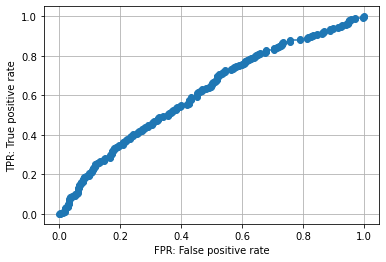

In [32]:
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, logi.predict_proba(x_test)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, logi.predict_proba(x_test)[:, 1])))

かなりスコアは良いかもしれない  
理由はおいおいわかりそうだが...

### 評価
ロジスティック回帰1強  
今後の学習はロジスティック回帰を使っていく

## 対数変換

In [33]:
x_l = x.copy()

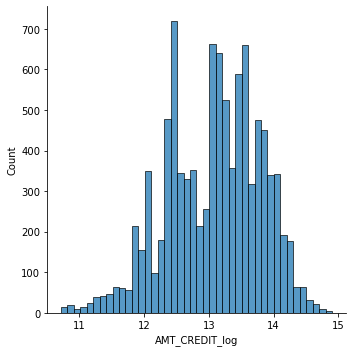

In [34]:
x_l['AMT_CREDIT_log'] = x_l['AMT_CREDIT'].apply(np.log) # 対数変換
sns.displot(x_l.AMT_CREDIT_log);

In [35]:
x_l.head()

,CODE_GENDER,NAME_FAMILY_STATUS,AMT_CREDIT,DAYS_BIRTH,AMT_CREDIT_log
0,0,3,406597.5,-9461,12.915579
1,1,1,1293502.5,-16765,14.072864
2,0,3,135000.0,-19046,11.813030
3,1,0,312682.5,-19005,12.652944
4,0,3,513000.0,-19932,13.148031


In [36]:
x_log = x_l.drop('AMT_CREDIT', axis=1)
x_log.head()

,CODE_GENDER,NAME_FAMILY_STATUS,DAYS_BIRTH,AMT_CREDIT_log
0,0,3,-9461,12.915579
1,1,1,-16765,14.072864
2,0,3,-19046,11.813030
3,1,0,-19005,12.652944
4,0,3,-19932,13.148031


### 評価

In [37]:
x_train_l, x_test_l = train_test_split(x_log.values, random_state=0).copy()

In [38]:
logi_l = LogisticRegression()
logi_l.fit(x_train_l, y_train)
logi_l_pred = logi_l.predict(x_test_l)
logi_l_confusion = me.confusion_matrix(y_true, logi_l_pred) 
print(logi_l_confusion) # 混同行列
print(classification_report(y_true, logi_l_pred))

[[2306    0]
 [ 194    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2306
           1       0.00      0.00      0.00       194

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,th_all,tpr_all,fpr_all
0,1.152172,0.000000,0.000000
1,0.152172,0.000000,0.000434
2,0.144373,0.000000,0.003903
3,0.144275,0.005155,0.003903
4,0.139755,0.005155,0.009974
...,...,...,...
364,0.038356,0.989691,0.989592
365,0.038356,0.994845,0.989592
366,0.037419,0.994845,0.996531
367,0.037344,1.000000,0.996531


AUC : 0.606772113983244


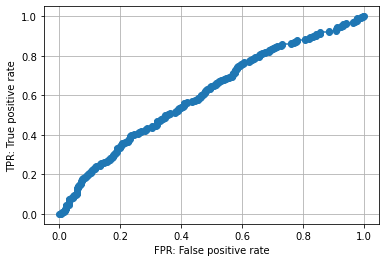

In [39]:
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, logi_l.predict_proba(x_test_l)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, logi_l.predict_proba(x_test_l)[:, 1])))

対数変換した方が結果は悪くなった。  
住宅価格の時は良くなったので考えられる原因は
- 対数変換したのが、目的変数ではなく説明変数のみ
- 分類問題だったため

## 標準化

In [40]:
x_train_df, x_test_df = train_test_split(x, random_state=0).copy() # df状態で分配

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train_df[['AMT_CREDIT', 'DAYS_BIRTH']])
x_train_h = scaler.transform(x_train_df[['AMT_CREDIT', 'DAYS_BIRTH']]) # 標準化できるものを標準化しhに格納
x_test_h = scaler.transform(x_test_df[['AMT_CREDIT', 'DAYS_BIRTH']])
x_train_h

array([[ 0.44254664, -1.64630957],
       [-1.25372076, -0.62210121],
       [-0.99022292, -0.21641725],
       ...,
       [-0.68230431,  0.26143939],
       [-1.07516982, -0.27387957],
       [-0.15566469, -0.33432993]])

In [42]:
x_train_df_2 = x_train_df.drop(['AMT_CREDIT', 'DAYS_BIRTH'], axis=1) # 標準化したものを削除
x_test_df_2 = x_test_df.drop(['AMT_CREDIT', 'DAYS_BIRTH'], axis=1) 
x_train_df_2

,CODE_GENDER,NAME_FAMILY_STATUS
2967,1,1
700,1,0
3481,1,0
1621,0,3
800,1,0
...,...,...
9225,1,1
4859,1,0
3264,0,1
9845,1,1


In [43]:
x_train_2 = x_train_df_2.values # dfをndarrayに
x_test_2 = x_test_df_2.values
x_train_h_2 = np.hstack([x_train_h, x_train_2])
x_test_h_2 = np.hstack([x_test_h, x_test_2])
x_test_h_2

array([[-0.64705257,  0.07480178,  0.        ,  1.        ],
       [-1.26840899, -1.28383727,  1.        ,  2.        ],
       [-0.86441605, -1.05191935,  1.        ,  1.        ],
       ...,
       [-0.18906928,  0.57472395,  0.        ,  1.        ],
       [ 0.17815859,  1.18474392,  0.        ,  0.        ],
       [-0.48325661, -0.82850586,  1.        ,  1.        ]])

### 評価

In [44]:
logi_h = LogisticRegression()
logi_h.fit(x_train_h_2, y_train)
logi_h_pred = logi_h.predict(x_test_h_2)
logi_h_confusion = me.confusion_matrix(y_true, logi_h_pred) 
print(logi_h_confusion) # 混同行列
print(classification_report(y_true, logi_h_pred))

[[2306    0]
 [ 194    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2306
           1       0.00      0.00      0.00       194

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,th_all,tpr_all,fpr_all
0,1.182648,0.000000,0.000000
1,0.182648,0.000000,0.000434
2,0.172285,0.000000,0.004337
3,0.171320,0.005155,0.004337
4,0.166051,0.005155,0.007806
...,...,...,...
350,0.036126,0.989691,0.978317
351,0.036113,0.994845,0.978317
352,0.029818,0.994845,0.998265
353,0.029716,1.000000,0.998265


AUC : 0.6095372001323307


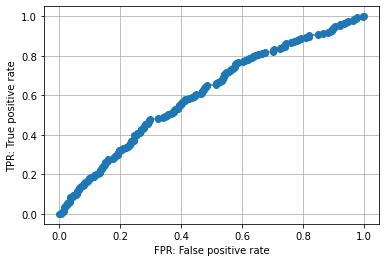

In [45]:
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, logi_h.predict_proba(x_test_h_2)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, logi_h.predict_proba(x_test_h_2)[:, 1])))

こちらも精度としては下がってる  
何でもかんでも標準化すればいいってわけではない  
可能性としては、'AMT_CREDIT', 'DAYS_BIRTH'の重みが深く、標準化したことで重みが減ってしまったこと。

## 特徴量の削減

- CODE_GENDER = c
- NAME_FAMILY_STATUS = n
- AMT_CREDIT = a
- DAYS_BIRTH = d

aが一番関係なさそうなので削ってみる

In [46]:
x_cnd = x.drop('AMT_CREDIT', axis=1)
x_train_cnd, x_test_cnd = train_test_split(x_cnd.values, random_state=0).copy()

### 評価

[[2306    0]
 [ 194    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2306
           1       0.00      0.00      0.00       194

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,th_all,tpr_all,fpr_all
0,1.222674,0.000000,0.000000
1,0.222674,0.000000,0.000434
2,0.220917,0.000000,0.002168
3,0.219641,0.005155,0.002168
4,0.215379,0.005155,0.003469
...,...,...,...
450,0.018547,0.989691,0.990026
451,0.018462,0.994845,0.990026
452,0.017579,0.994845,0.997398
453,0.017357,1.000000,0.997398


AUC : 0.6005422877120198


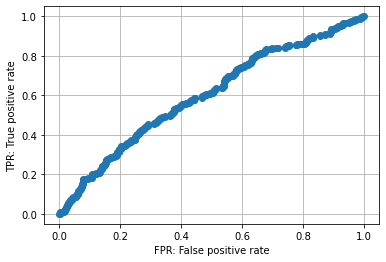

In [47]:
logi_cnd = LogisticRegression()
logi_cnd.fit(x_train_cnd, y_train)
logi_cnd_pred = logi_cnd.predict(x_test_cnd)
logi_cnd_confusion = me.confusion_matrix(y_true, logi_cnd_pred) 
print(logi_cnd_confusion) # 混同行列
print(classification_report(y_true, logi_cnd_pred))
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, logi_cnd.predict_proba(x_test_cnd)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, logi_cnd.predict_proba(x_test_cnd)[:, 1])))

特徴量を削減することでスコアは若干下がった  
追加すれば上がるかも！　　



ちなみに他のデータを削ると

In [48]:
x_nad = x.drop('CODE_GENDER', axis=1)
x_train_nad, x_test_nad = train_test_split(x_nad.values, random_state=0).copy()

[[2306    0]
 [ 194    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2306
           1       0.00      0.00      0.00       194

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,th_all,tpr_all,fpr_all
0,1.232335,0.000000,0.000000
1,0.232335,0.000000,0.000434
2,0.230754,0.000000,0.001301
3,0.229561,0.005155,0.001301
4,0.210383,0.005155,0.012142
...,...,...,...
353,0.023893,0.989691,0.969644
354,0.017928,0.989691,0.996964
355,0.017884,0.994845,0.996964
356,0.014933,0.994845,1.000000


AUC : 0.6148863118176697


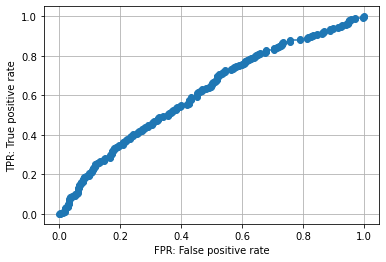

In [49]:
logi_nad = LogisticRegression()
logi_nad.fit(x_train_nad, y_train)
logi_nad_pred = logi_nad.predict(x_test_nad)
logi_nad_confusion = me.confusion_matrix(y_true, logi_nad_pred) 
print(logi_nad_confusion) # 混同行列
print(classification_report(y_true, logi_nad_pred))
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, logi_nad.predict_proba(x_test_nad)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, logi_nad.predict_proba(x_test_nad)[:, 1])))

genderを削除してもスコアは下がった！

In [50]:
x_gad = x.drop('NAME_FAMILY_STATUS', axis=1)
x_train_gad, x_test_gad = train_test_split(x_gad.values, random_state=0).copy()

[[2306    0]
 [ 194    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2306
           1       0.00      0.00      0.00       194

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,th_all,tpr_all,fpr_all
0,1.232335,0.000000,0.000000
1,0.232335,0.000000,0.000434
2,0.230754,0.000000,0.001301
3,0.229561,0.005155,0.001301
4,0.210383,0.005155,0.012142
...,...,...,...
353,0.023893,0.989691,0.969644
354,0.017928,0.989691,0.996964
355,0.017884,0.994845,0.996964
356,0.014933,0.994845,1.000000


AUC : 0.6148863118176697


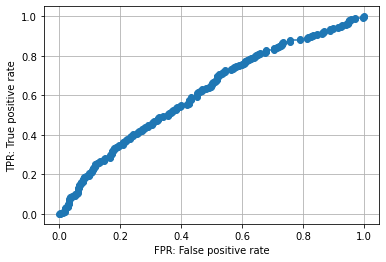

In [51]:
logi_gad = LogisticRegression()
logi_gad.fit(x_train_gad, y_train)
logi_gad_pred = logi_gad.predict(x_test_gad)
logi_gad_confusion = me.confusion_matrix(y_true, logi_gad_pred) 
print(logi_gad_confusion) # 混同行列
print(classification_report(y_true, logi_gad_pred))
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, logi_gad.predict_proba(x_test_gad)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, logi_gad.predict_proba(x_test_gad)[:, 1])))

genderを削った時と全く同じスコアになった。  
ということは全く同じ重みになってる？  
あるいはカテゴリー系の重みは一定なのか？

In [52]:
x_gan = x.drop('DAYS_BIRTH', axis=1)
x_train_gan, x_test_gan = train_test_split(x_gan.values, random_state=0).copy()

[[2306    0]
 [ 194    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2306
           1       0.00      0.00      0.00       194

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,th_all,tpr_all,fpr_all
0,1.452972,0.000000,0.000000
1,0.452972,0.000000,0.000434
2,0.452972,0.000000,0.000867
3,0.449888,0.000000,0.001735
4,0.449888,0.000000,0.002168
...,...,...,...
675,0.000080,0.994845,0.997832
676,0.000035,0.994845,0.998699
677,0.000026,0.994845,0.999566
678,0.000012,0.994845,1.000000


AUC : 0.5660345937536324


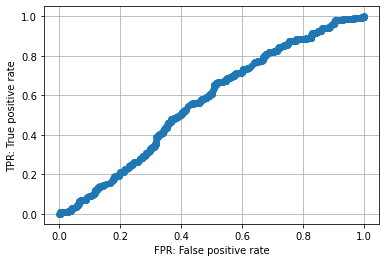

In [53]:
logi_gan = LogisticRegression()
logi_gan.fit(x_train_gan, y_train)
logi_gan_pred = logi_gan.predict(x_test_gan)
logi_gan_confusion = me.confusion_matrix(y_true, logi_gan_pred) 
print(logi_gan_confusion) # 混同行列
print(classification_report(y_true, logi_gan_pred))
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, logi_gan.predict_proba(x_test_gan)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, logi_gan.predict_proba(x_test_gan)[:, 1])))

ものすごく下がった。4パターン全て行いわかったのが重要度は
1. DAYS_BIRTH 
2. AMT_CREDIT 
3. CODE_GENDER = NAME_FAMILY_STATUS 
  
の順番だった！

## 特徴量の追加
次に良さそうだったAMT_INCOME_TOTALを追加

In [54]:
x2 = df[['CODE_GENDER', 'NAME_FAMILY_STATUS', 'AMT_CREDIT', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL']].copy()
x2['CODE_GENDER'] = x2['CODE_GENDER'].map({'M' : 0, 'F' : 1}).astype(int) # 性別のダミー変数
x2['NAME_FAMILY_STATUS'] = x2['NAME_FAMILY_STATUS'].map({'Civil marriage' : 0, 'Married' : 1, 'Separated' : 2, 'Single / not married' : 3, 'Widow' : 4}).astype(int) # 性別のダミー変数
x2_train, x2_test = train_test_split(x2.values, random_state=0).copy()

### 評価

[[2306    0]
 [ 194    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2306
           1       0.00      0.00      0.00       194

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,th_all,tpr_all,fpr_all
0,1.231997,0.000000,0.000000
1,0.231997,0.000000,0.000434
2,0.223233,0.000000,0.002168
3,0.218610,0.005155,0.002168
4,0.202633,0.005155,0.007372
...,...,...,...
348,0.014631,0.989691,0.996964
349,0.014470,0.994845,0.996964
350,0.010516,0.994845,0.999133
351,0.007913,1.000000,0.999133


AUC : 0.6061864611367924


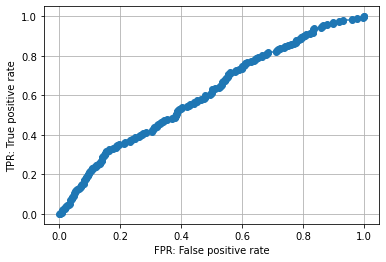

In [55]:
logi2 = LogisticRegression()
logi2.fit(x2_train, y_train)
logi2_pred = logi2.predict(x2_test)
logi2_confusion = me.confusion_matrix(y_true, logi2_pred) 
print(logi2_confusion)
print(classification_report(y_true, logi2_pred))
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, logi2.predict_proba(x2_test)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, logi2.predict_proba(x2_test)[:, 1])))

がっつり下がった笑

'DAYS_REGISTRATION'の場合

In [56]:
x3 = df[['CODE_GENDER', 'NAME_FAMILY_STATUS', 'AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_REGISTRATION']].copy()
x3['CODE_GENDER'] = x3['CODE_GENDER'].map({'M' : 0, 'F' : 1}).astype(int) # 性別のダミー変数
x3['NAME_FAMILY_STATUS'] = x3['NAME_FAMILY_STATUS'].map({'Civil marriage' : 0, 'Married' : 1, 'Separated' : 2, 'Single / not married' : 3, 'Widow' : 4}).astype(int) # 性別のダミー変数
x3_train, x3_test = train_test_split(x3.values, random_state=0).copy()

[[2306    0]
 [ 194    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2306
           1       0.00      0.00      0.00       194

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,th_all,tpr_all,fpr_all
0,1.239070,0.000000,0.000000
1,0.239070,0.005155,0.000000
2,0.217746,0.005155,0.007372
3,0.217283,0.010309,0.007372
4,0.214259,0.010309,0.008673
...,...,...,...
349,0.023009,0.989691,0.962272
350,0.020727,0.989691,0.979185
351,0.020722,0.994845,0.979185
352,0.012058,0.994845,1.000000


AUC : 0.6171998640927746


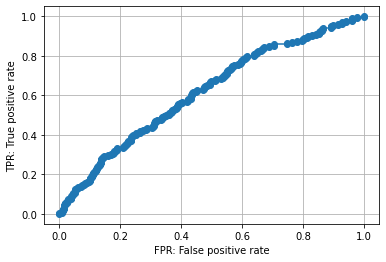

In [57]:
logi3 = LogisticRegression()
logi3.fit(x3_train, y_train)
logi3_pred = logi3.predict(x3_test)
logi3_confusion = me.confusion_matrix(y_true, logi3_pred) 
print(logi3_confusion)
print(classification_report(y_true, logi3_pred))
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, logi3.predict_proba(x3_test)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, logi3.predict_proba(x3_test)[:, 1])))

ほんとに若干だが上がった！  
関係はあったみたい！

## 全データでの検証

In [58]:
dff = dataset
yf = dff['TARGET'].copy()
xf = dff[['CODE_GENDER', 'NAME_FAMILY_STATUS', 'AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_REGISTRATION']].copy()

In [59]:
unique_name, count = np.unique(xf.CODE_GENDER, return_counts=True) # 閾値とそれを超える値を格納
pd.DataFrame(list(zip(unique_name, count)), columns = ['unique_name','count'], index=dff.CODE_GENDER.unique())

,unique_name,count
M,F,202448
F,M,105059
XNA,XNA,4


In [60]:
unique_name, count = np.unique(xf.NAME_FAMILY_STATUS, return_counts=True) # 閾値とそれを超える値を格納
pd.DataFrame(list(zip(unique_name, count)), columns = ['unique_name','count'], index=dff.NAME_FAMILY_STATUS.unique())

,unique_name,count
Single / not married,Civil marriage,29775
Married,Married,196432
Civil marriage,Separated,19770
Widow,Single / not married,45444
Separated,Unknown,2
Unknown,Widow,16088


In [61]:
xf['CODE_GENDER'] = xf['CODE_GENDER'].map({'M' : 0, 'F' : 1, 'XNA' : 2}).astype(int) # 性別のダミー変数
xf['NAME_FAMILY_STATUS'] = xf['NAME_FAMILY_STATUS'].map({'Civil marriage' : 0, 'Married' : 1, 'Separated' : 2, 'Single / not married' : 3, 'Widow' : 4, 'Unknown' : 5}).astype(int) # 性別のダミー変数

In [62]:
xf_train, xf_test = train_test_split(xf.values, random_state=0).copy()
yf_train, yf_true = train_test_split(yf.values, random_state=0).copy()

### 評価

[[70787     0]
 [ 6091     0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70787
           1       0.00      0.00      0.00      6091

    accuracy                           0.92     76878
   macro avg       0.46      0.50      0.48     76878
weighted avg       0.85      0.92      0.88     76878



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,th_all,tpr_all,fpr_all
0,1.255797,0.000000,0.000000
1,0.255797,0.000000,0.000014
2,0.252527,0.000000,0.000085
3,0.252144,0.000164,0.000085
4,0.251473,0.000164,0.000099
...,...,...,...
11191,0.015380,0.999672,0.999251
11192,0.015283,0.999836,0.999251
11193,0.013218,0.999836,0.999774
11194,0.013157,1.000000,0.999774


AUC : 0.5860902150285097


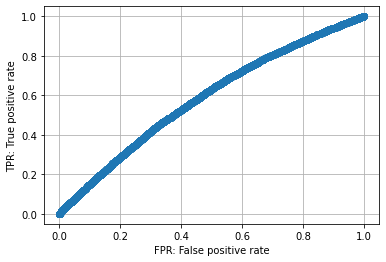

In [63]:
logi_f = LogisticRegression()
logi_f.fit(xf_train, yf_train)
logi_f_pred = logi_f.predict(xf_test)
logi_f_confusion = me.confusion_matrix(yf_true, logi_f_pred) 
print(logi_f_confusion)
print(classification_report(yf_true, logi_f_pred))
fpr_all, tpr_all, th_all  = me.roc_curve(yf_true, logi_f.predict_proba(xf_test)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(yf_true, logi_f.predict_proba(xf_test)[:, 1])))

信じられないくらい精度は落ちた  
実行時間はそこまでかからなかった.  
外れ値の問題かサンプル時のかたより(10000も引っ張ったしそれはないと思うけど)の可能性が高い  
過学習の可能性もある

## テストデータでの実行

In [73]:
testdata = pd.read_csv('application_test.csv')
x_testdata = testdata[['CODE_GENDER', 'NAME_FAMILY_STATUS', 'AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_REGISTRATION']].copy() # データの読み込み

In [65]:
x_testdata['CODE_GENDER'] = x_testdata['CODE_GENDER'].map({'M' : 0, 'F' : 1, 'XNA' : 2}).astype(int) # 性別のダミー変数
x_testdata['NAME_FAMILY_STATUS'] = x_testdata['NAME_FAMILY_STATUS'].map({'Civil marriage' : 0, 'Married' : 1, 'Separated' : 2, 'Single / not married' : 3, 'Widow' : 4, 'Unknown' : 5}).astype(int) # 性別のダミー変数

In [66]:
logi_pred_testdata = logi_f.predict(x_testdata.values) # 結果の出力

In [67]:
unique_name, count = np.unique(logi_pred_testdata, return_counts=True) # 閾値とそれを超える値を格納
pd.DataFrame(list(zip(unique_name, count)), columns = ['unique_name','count'])

,unique_name,count
0,0,48744


案の定確率で出さない限りは0で出力される。

In [68]:
logi_pred_proba_testdata = logi_f.predict_proba(x_testdata.values) # 確率密度での結果の出力

In [69]:
result = pd.DataFrame(logi_f.predict_proba(x_testdata)[:, 1], columns=['TARGET']) # dfにして保存

In [70]:
x_testdata_id = testdata[['SK_ID_CURR']].copy() # idの列の抽出

In [71]:
result_1 = pd.concat([x_testdata_id, result], axis=1)
RESULT = result_1.set_index('SK_ID_CURR') # 結合とindexの振り直し

In [74]:
RESULT.to_csv('result.csv', index=False)